In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
#collapse_output
!unzip /content/drive/My\ Drive/BDD/bdd100k_labels_detection20.zip

In [4]:
%%capture
#collapse_output
!unzip /content/drive/My\ Drive/BDD/bdd100k_images.zip

In [5]:
#hide
from pathlib import Path
import shutil
import json
import os

# Convert bdd format to coco format
This function will take **from_file** json bdd format labels file and will create and save a new json coco format file to **save_to**/labels folder. You may also specify **path_to_images** value, but if not set, **from_file**/images/100k will be taken as default. Set **copy_images** to True if you want to copy images from bdd (make sense if you want to create a mini-version of the dataset). Set **make_zip** to True if you want to make a zip archive of your dataset. **remove_folder** will delete **save_to** before working with it. Make **dataset_type** equal to 0 if working with train dataset, 1 - validation dataset.

In [6]:
def bdd2coco(from_file, save_to, size=10, path_to_images=None, copy_images=True, labels_filename="labels", make_zip=False, remove_folder=True, dataset_type=0):
  '''
  copy_images: copy images from bdd dataset
  labels_filename: output json filename
  make_zip: create a zip archive containing images/labels
  remove_folder: clean save_to folder before saving images/labels to it
  dataset_type: 0 - train, 1 - val
  '''
  annotations, categories, images = [], [], []
  ann_list, cat_list, img_list = [], [], []

  # Create temporary dict
  img_temp = {}
  cat_temp = {}

  cat_id = 0
  for idx, annotation in enumerate(json.load(open(from_file))):
    if idx >= size:
      break
    
    if annotation['name'] not in img_temp:
      img_temp[annotation['name']] = annotation['name'].split('.')[0]
      images.append({'file_name' : annotation['name'], 'id' : annotation['name'].split('.')[0]})
    
    if annotation['labels'] is not None:
      for label in annotation['labels']:
        box2d = label['box2d']
        bbox = [box2d['x1'], box2d['y1'], box2d['x2'] - box2d['x1'], box2d['y2'] - box2d['y1']]

        if label['category'] not in cat_temp:
          cat_temp[label['category']] = cat_id
          categories.append({'id' : cat_id, 'name' : label['category']})
          cat_id += 1
        
        box_annotation = {}
        box_annotation['bbox'] = bbox
        box_annotation['category_id'] = cat_temp[label['category']]
        box_annotation['image_id'] = img_temp[annotation['name']]
        annotations.append(box_annotation)

  coco = {'annotations' : annotations, 'images' : images, 'categories' : categories}

  if remove_folder and Path(save_to).exists() and Path(save_to).is_dir():
    shutil.rmtree(save_to)

  Path(save_to).mkdir(parents=True, exist_ok=True)
  Path(save_to + '/labels').mkdir(parents=True, exist_ok=True)

  with open(save_to + '/labels/' + labels_filename + '.json', 'w+') as outfile:
    json.dump(coco, outfile)

  data = json.load(open(save_to + '/labels/' + labels_filename + '.json'))

  if copy_images:
    Path(save_to + '/images').mkdir(parents=True, exist_ok=True)
    if dataset_type == 0:
      Path(save_to + '/images/train').mkdir(parents=True, exist_ok=True)
    elif dataset_type == 1:
      Path(save_to + '/images/val').mkdir(parents=True, exist_ok=True)

    if path_to_images is None:
      path_to_images = Path(Path(from_file).parent.parent.parent/'images/100k')
    for d in data['images']:
      if dataset_type == 0:
        shutil.copy(path_to_images/'train'/d['file_name'], save_to + '/images/train')
      elif dataset_type == 1:
        shutil.copy(path_to_images/'val'/d['file_name'], save_to + '/images/val')

  archive_name = save_to.split('/')[-1]
  
  if make_zip:
    os.system("zip -r " + archive_name + ".zip "  + save_to)

In [7]:
#hide
import collections

In [8]:
#hide

#fastcore: https://github.com/fastai/fastcore/blob/fe2d09fa507becc8a3d980c62421f4cb86b9e736/fastcore/basics.py#L25
def ifnone(a, b):
    "`b` if `a` is None else `a`"
    return b if a is None else a

#fastai: https://github.com/fastai/fastai/blob/493023513ddd5157647bd10e9cebbbbdc043474c/fastai/vision/core.py#L165
def get_annotations(fname, prefix=None):
    "Open a COCO style json in `fname` and returns the lists of filenames (with maybe `prefix`) and labelled bboxes."
    annot_dict = json.load(open(fname))
    id2images, id2bboxes, id2cats = {}, collections.defaultdict(list), collections.defaultdict(list)
    classes = {o['id']:o['name'] for o in annot_dict['categories']}
    for o in annot_dict['annotations']:
        bb = o['bbox']
        id2bboxes[o['image_id']].append([bb[0],bb[1], bb[0]+bb[2], bb[1]+bb[3]])
        id2cats[o['image_id']].append(classes[o['category_id']])
    id2images = {o['id']:ifnone(prefix, '') + o['file_name'] for o in annot_dict['images'] if o['id'] in id2bboxes}
    ids = list(id2images.keys())
    return [id2images[k] for k in ids], [(id2bboxes[k], id2cats[k]) for k in ids]

In [9]:
#hide
import time

Test run:

In [10]:

start = time.time()
bdd2coco('/content/bdd100k/labels/detection20/det_v2_train_release.json', '/content/temp', labels_filename="labels_train", dataset_type=0, remove_folder=True)
bdd2coco('/content/bdd100k/labels/detection20/det_v2_val_release.json', '/content/temp', labels_filename="labels_val", dataset_type=1, remove_folder=False)
finish = time.time()

print("bdd2coco finished in: ", finish - start)

bdd2coco finished in:  18.659612894058228


Read images and labels from newly created file

In [11]:
images, lbl_bbox = get_annotations('/content/temp/labels/labels_train.json')
img2bbox = dict(zip(images, lbl_bbox))
pic = images[0]
img2bbox[pic]

([[1125.902264, 133.184488, 1156.978645, 210.875445],
  [1156.978645, 136.637417, 1191.50796, 210.875443],
  [1105.66915985699, 211.122087, 1170.79037, 233.566141],
  [0, 0.246631, 100.381647, 122.825696],
  [49.44476737704903, 254.530367, 357.805838, 487.906215],
  [507.82755, 221.727518, 908.367588, 441.0052451528153],
  [0.156955, 0.809282, 102.417429, 133.411856]],
 ['traffic light',
  'traffic light',
  'traffic sign',
  'traffic sign',
  'car',
  'car',
  'traffic sign'])

In [12]:
#hide
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from matplotlib import pyplot as plt

Helper functions to show images

In [13]:
#ultralytics/yolov5: https://github.com/ultralytics/yolov5/blob/98a46d8e82969445cecfae2aa21929dbebd6a3de/utils/plots.py#L29
def color_list():
    # Return first 10 plt colors as (r,g,b) https://stackoverflow.com/questions/51350872/python-from-color-name-to-rgb
    def hex2rgb(h):
        return tuple(int(h[1 + i:1 + i + 2], 16) for i in (0, 2, 4))

    return [hex2rgb(h) for h in plt.rcParams['axes.prop_cycle'].by_key()['color']]

def show_detections(img, boxes=None, categories=None, category_ids=None):
  colors = color_list()
  draw = ImageDraw.Draw(img)
  font_size_pil = 16
  font_pil = ImageFont.truetype("/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf", size=font_size_pil)

  for idx, box in enumerate(boxes):
    draw.rectangle([box[0], box[1], box[2], box[3]], width=4, outline=colors[int(category_ids[idx]) % 10])  # box
    text_size = draw.textsize(categories[idx], font_pil)

    draw.rectangle([box[0], box[1] - text_size[1], box[0] + text_size[0], box[1]], fill=colors[int(category_ids[idx]) % 10])  # box for text
    draw.text([box[0], box[1] - text_size[1]], categories[idx], color=(255, 255, 255), font=font_pil) # text

  display(img)

Let`s create a mini dataset with only 128 images

In [14]:
bdd2coco('/content/bdd100k/labels/detection20/det_v2_train_release.json', '/content/bdd_mini', labels_filename="labels", size=128)
images, lbl_bbox = get_annotations('/content/bdd_mini/labels/labels.json')
img2bbox = dict(zip(images, lbl_bbox))

Check how many images were saved

In [15]:
!find /content/bdd_mini/images -type f | wc -l

128


Map categories names to ids 

In [16]:
with open('/content/bdd_mini/labels/labels.json') as json_file:
  categories = {x['name'] : idx for idx, x in enumerate(json.load(json_file)['categories'])}

In [17]:
#hide
import cv2
from pathlib import Path
from google.colab.patches import cv2_imshow
import numpy as np
import torch

In [18]:
def show_images(img2bbox, images, path='/content/bdd100k/images/100k/train/', count=1):
  for i in range(count):
    img = Image.open(path + images[i])
    bboxes = torch.tensor(img2bbox[images[i]][0]).int()
    cats = img2bbox[images[i]][1]
    show_detections(img, bboxes, cats, [categories[name] for name in cats])

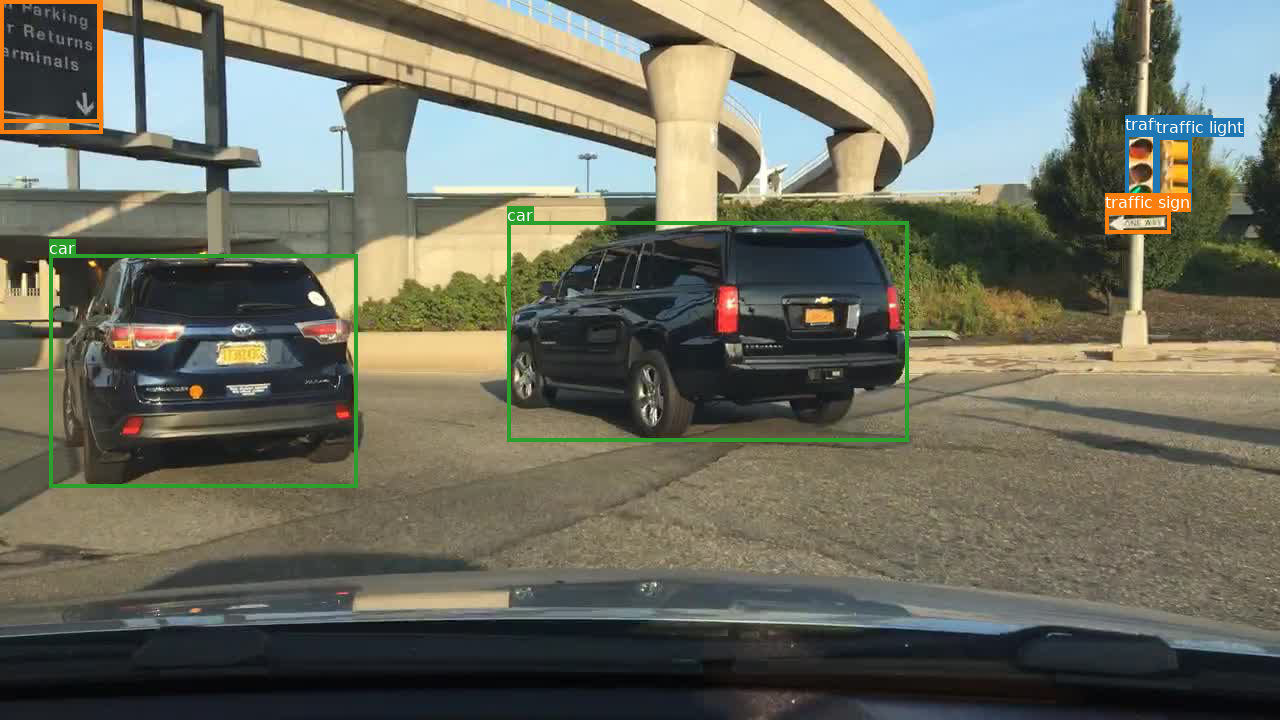

In [19]:
#collapse_output
show_images(img2bbox, images, path='/content/bdd_mini/images/train/', count=1)